# Understanding the 2016 Voting Structure

In this script, I perform a Principle Component Analysis on the US States based on 2016 socio-economic and demographic features. I then see how relevant the two first axes of the PCA are at explaining Donald Trump's election. The analysis is performed on all US States, and on a subset of 14 Swing States.

Results show that for both the entire United States and the Swing States, the clustering of US States using the first 2 axes of the PCA are relevant in explaining vote. Swing States in particular can be clustered into "Safe Democrat" (these states voted for Obama in 2012 and Clinton in 2016), "Safe Republican" (having voted for Romney in 2012 and Trump in 2016), and "The Swing of the Swing States": a subset of States that voted for Obama in 2012 and Trump in 2016.

A further analysis looks are the polling error in Donald Trump's favor. The polling numbers used here are the [final predictions of FiveThirtyEight.com](https://projects.fivethirtyeight.com/2016-election-forecast/). Preliminary calculations indicate that PCA axes 2 and 3 are actually the most relevant in explaining the polling error – indicating that unlike voting, the polling error was not due to the most important socio-economic and demographic fractures among Swing States. 

The main findings are that Trump massively overperformed in older, whiter states, but also in Swing States with a strong African-American presence. [A post-mortem analysis in the Washington Post](https://www.washingtonpost.com/news/monkey-cage/wp/2017/05/08/why-did-trump-win-more-whites-and-fewer-blacks-than-normal-actually-voted/?noredirect=on&utm_term=.4ad3fbe49836) indicates that while Trump found his base in older, White voters, an sub-expectation vote among African-Americans also swung states like Michigan in his favor.

## Import Packages

In [130]:
import pandas as pd
import sklearn
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from matplotlib import collections as mc

## Import Data

In [2]:
df = pd.read_csv('../input/data.csv')

## Pre-processing and Functions

In [3]:
df['winner_2012'] = np.where(df['pct_obama_2012']>df['pct_romney_2012'], "D", "R")
df['winner_2016'] = np.where(df['pct_clinton_2016']>df['pct_trump_2016'], "D", "R")
df['poll_error_trump_2016'] = df['pct_trump_2016'] - df['poll_trump_2016']

In [4]:
swing_states = ['Arizona', 'Colorado', 'Florida', 'Georgia', 'Michigan', 'Minnesota', 'Nevada', 'NewHampshire'
                , 'NewMexico', 'NorthCarolina', 'Ohio', 'Pennsylvania', 'Virginia', 'Wisconsin']
pca_vars = ['age_18_29', 'age_30_44', 'age_45_64', 'age_Over65', 'white', 'african_american', 'latino'
            , 'poverty_rate', 'hh_income_over100k_rate', 'unemployment_rate'
            , 'college_educated_rate', 'gun_ownership_rate', 'adult_obesity_rate']
proj_vars = ['pct_clinton_2016', 'pct_trump_2016', 'poll_error_trump_2016', 'pct_obama_2012', 'pct_romney_2012']
info_vars = ['state', 'abbreviation', 'winner_2012', 'winner_2016', 'poll_error_trump_2016']

In [6]:
def data_processing(df):
    X = df[pca_vars]
    info = df[info_vars]
    return X, info

In [7]:
def pca_analysis(X, components = 2):
    X_std = StandardScaler().fit_transform(X)
    sklearn_pca = sklearnPCA(n_components = components)
    c_alpha = sklearn_pca.fit_transform(X_std)
    d_alpha = sklearn_pca.transform(np.eye(len(pca_vars)))
    return c_alpha, d_alpha

In [8]:
def pca_plot(pca_x, pca_y, vars_x, vars_y, lines, color, name, axes = [1,2]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (26,13))
    
    ax1.scatter(pca_x, pca_y, c = color)
    ax1.scatter(vars_x, vars_y, c = 'black', marker = 'x') 
    lc = mc.LineCollection(lines, colors='black', linewidths=2)
    ax1.add_collection(lc)
    for i, txt in enumerate(pca_vars):
        ax1.annotate(txt, (vars_x[i], vars_y[i]), fontsize = 15, color = 'black');
    ax1.set_xlabel('PCA Axis {}'.format(axes[0]), fontsize = 20)
    ax1.set_ylabel('PCA Axis {}'.format(axes[1]), fontsize = 20)
    
    ax2.scatter(vars_x, vars_y, c = 'grey', marker = 'x')
    for i, txt in enumerate(pca_vars):
        ax2.annotate(txt, (vars_x[i], vars_y[i]), fontsize = 13, color = 'grey');
    lc = mc.LineCollection(lines, colors='grey', linewidths=2)
    ax2.add_collection(lc)
    ax2.scatter(pca_x, pca_y, c = color)
    for i, txt in enumerate(name):
        ax2.annotate(txt, (pca_x[i], pca_y[i]), fontsize = 15, color = 'black');
    ax2.set_xlabel('PCA Axis {}'.format(axes[0]), fontsize = 20)
    ax2.set_ylabel('PCA Axis {}'.format(axes[1]), fontsize = 20)
    
    fig.suptitle('Principal Component Analysis of US States', fontsize=35)

In [9]:
def votes_plot(c_alpha, d_alpha, info, scale_factor = 1):
    pca_x = c_alpha[:,0]
    pca_y = c_alpha[:,1]
    vars_x = scale_factor*d_alpha[:,0]
    vars_y = scale_factor*d_alpha[:,1]
    lines = []
    for i in range(len(pca_vars)):
        lines.append([(0, 0), (scale_factor*d_alpha[:,0][i], scale_factor*d_alpha[:,1][i])])

    color = np.where(info['winner_2016'] == 'R', 'red', 'blue')
    name = info['abbreviation']
    
    pca_plot(pca_x, pca_y, vars_x, vars_y, lines, color, name)

In [10]:
def poll_plot(c_alpha, d_alpha, info, scale_factor = 1):
    pca_x = c_alpha[:,1]
    pca_y = c_alpha[:,2]
    vars_x = scale_factor*d_alpha[:,1]
    vars_y = scale_factor*d_alpha[:,2]
    lines = []
    for i in range(len(pca_vars)):
        lines.append([(0, 0), (scale_factor*d_alpha[:,1][i], scale_factor*d_alpha[:,2][i])])

    color = info['poll_error_trump_2016']
    name = info['abbreviation']
    
    pca_plot(pca_x, pca_y, vars_x, vars_y, lines, color, name, axes = [2,3])

In [207]:
def k_means_plot(X, k, info):
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    C = kmeans.cluster_centers_
    
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01
    
    # Plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))    
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]) # Obtain labels for each point in mesh.       
    Z = Z.reshape(xx.shape)
    
    plt.subplots(figsize = (10,10))
    plt.clf()
    plt.imshow(Z, cmap=plt.cm.Pastel2, interpolation='nearest', 
               extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto', origin='lower')
    
    name = info['abbreviation']
    color = np.where(info['winner_2016']=='R', 'red', 'blue')
    for x, y, c in zip(X[:,0], X[:,1], color):
        plt.scatter(x, y, c = c, marker='o', s = 40)
    plt.scatter(C[:,0], C[:,1], marker = '*', c = 'black', s = 500)
    for i, txt in enumerate(name):
        plt.annotate(txt, (X[:,0][i], X[:,1][i]), fontsize = 13, color = 'black');

## USA Analysis

In [208]:
data = df[df['abbreviation']!="DC"].reset_index(drop = True)

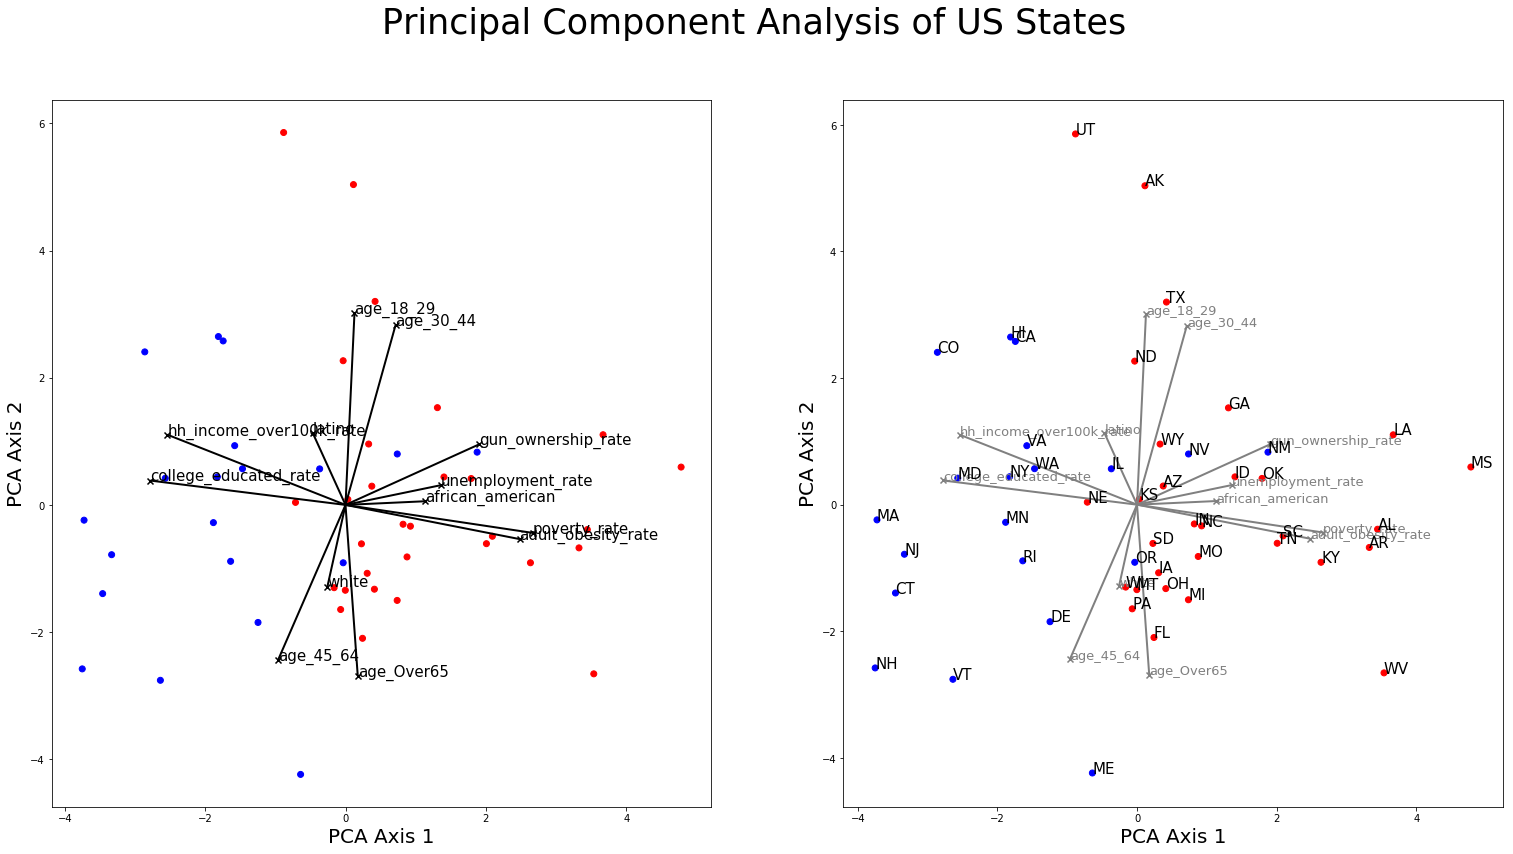

In [209]:
X, info = data_processing(data)
c_alpha, d_alpha = pca_analysis(X)
votes_plot(c_alpha, d_alpha, info, scale_factor=6)

### K-Means Clustering on PCA Axes 1 and 2

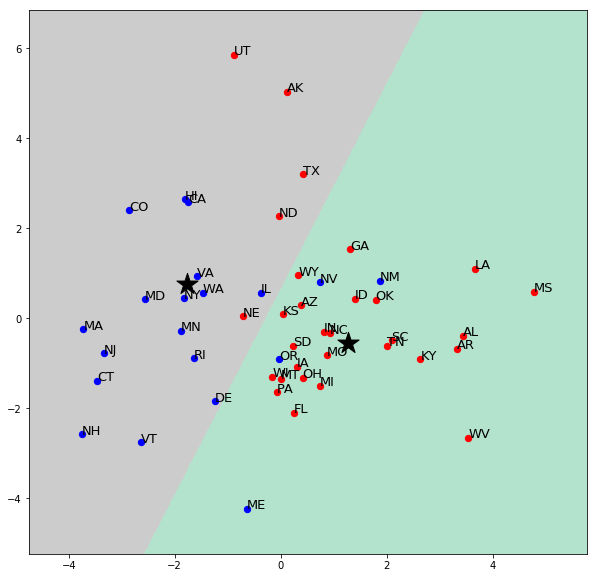

In [210]:
k_means_plot(c_alpha, 2, info)

## Swing State Analysis

In [211]:
data = df[df['state'].apply(lambda x: x in swing_states)].reset_index(drop = True)

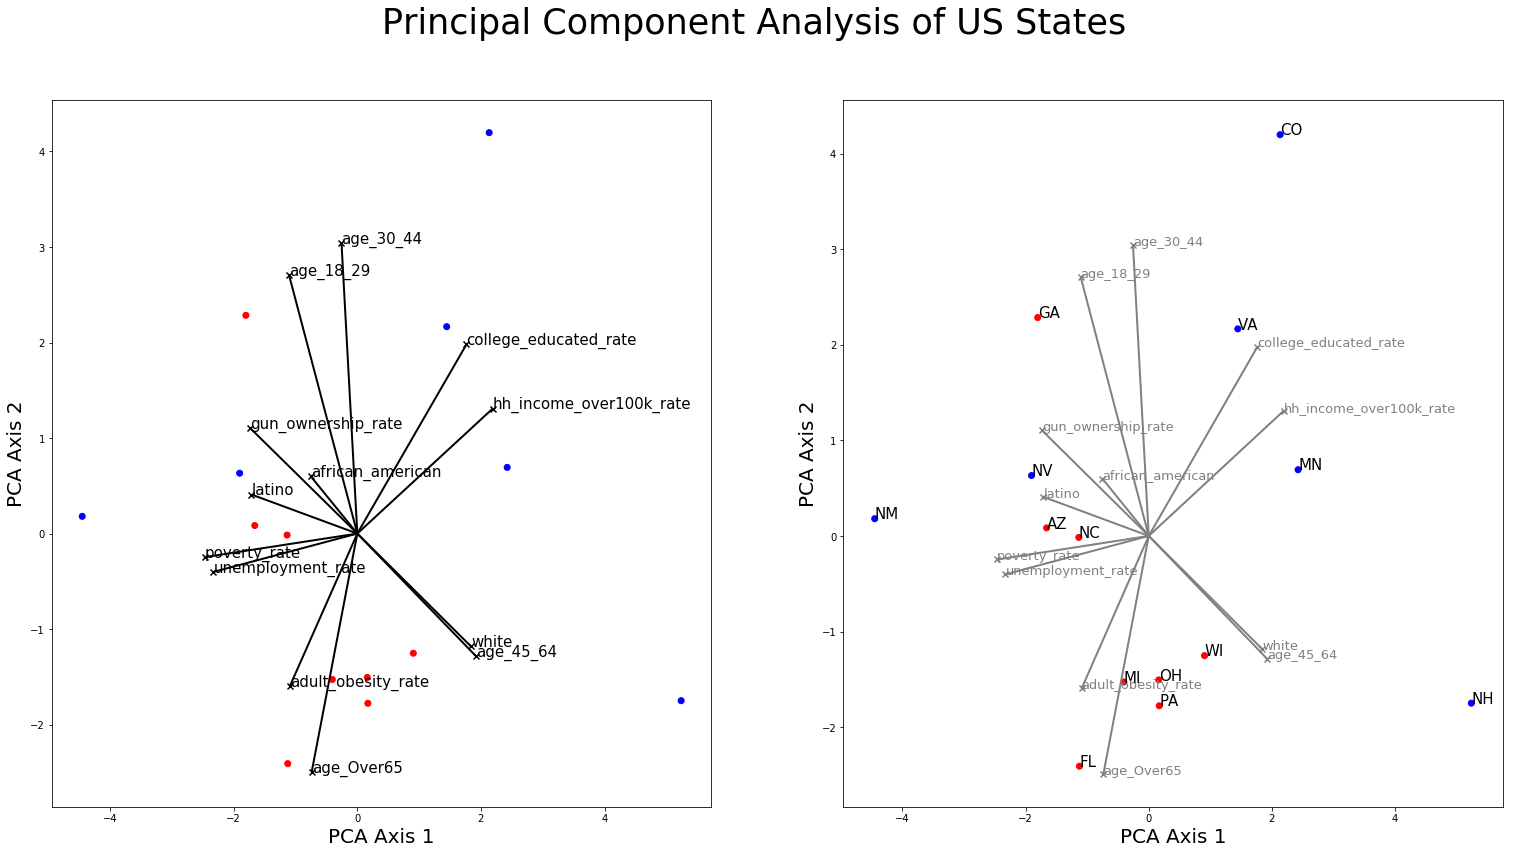

In [212]:
X, info = data_processing(data)
c_alpha, d_alpha = pca_analysis(X)
votes_plot(c_alpha, d_alpha, info, scale_factor=6)

### K-Means Clustering on PCA Axes 1 and 2

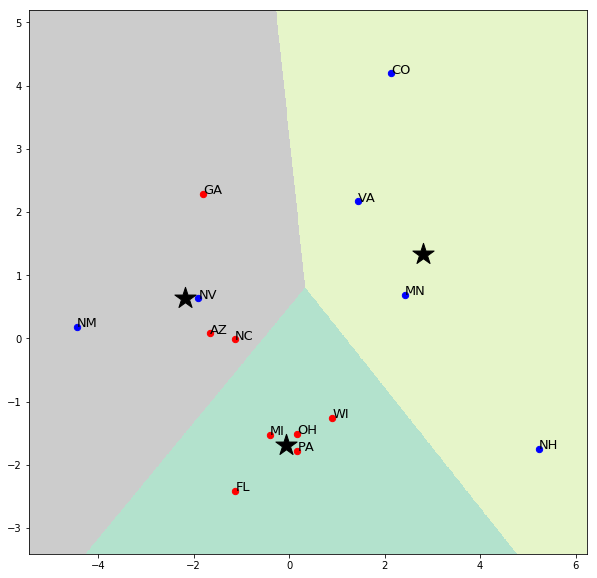

In [213]:
k_means_plot(c_alpha, 3, info)

## Polling Error Analysis

In [214]:
data = df[df['state'].apply(lambda x: x in swing_states)].reset_index(drop = True)

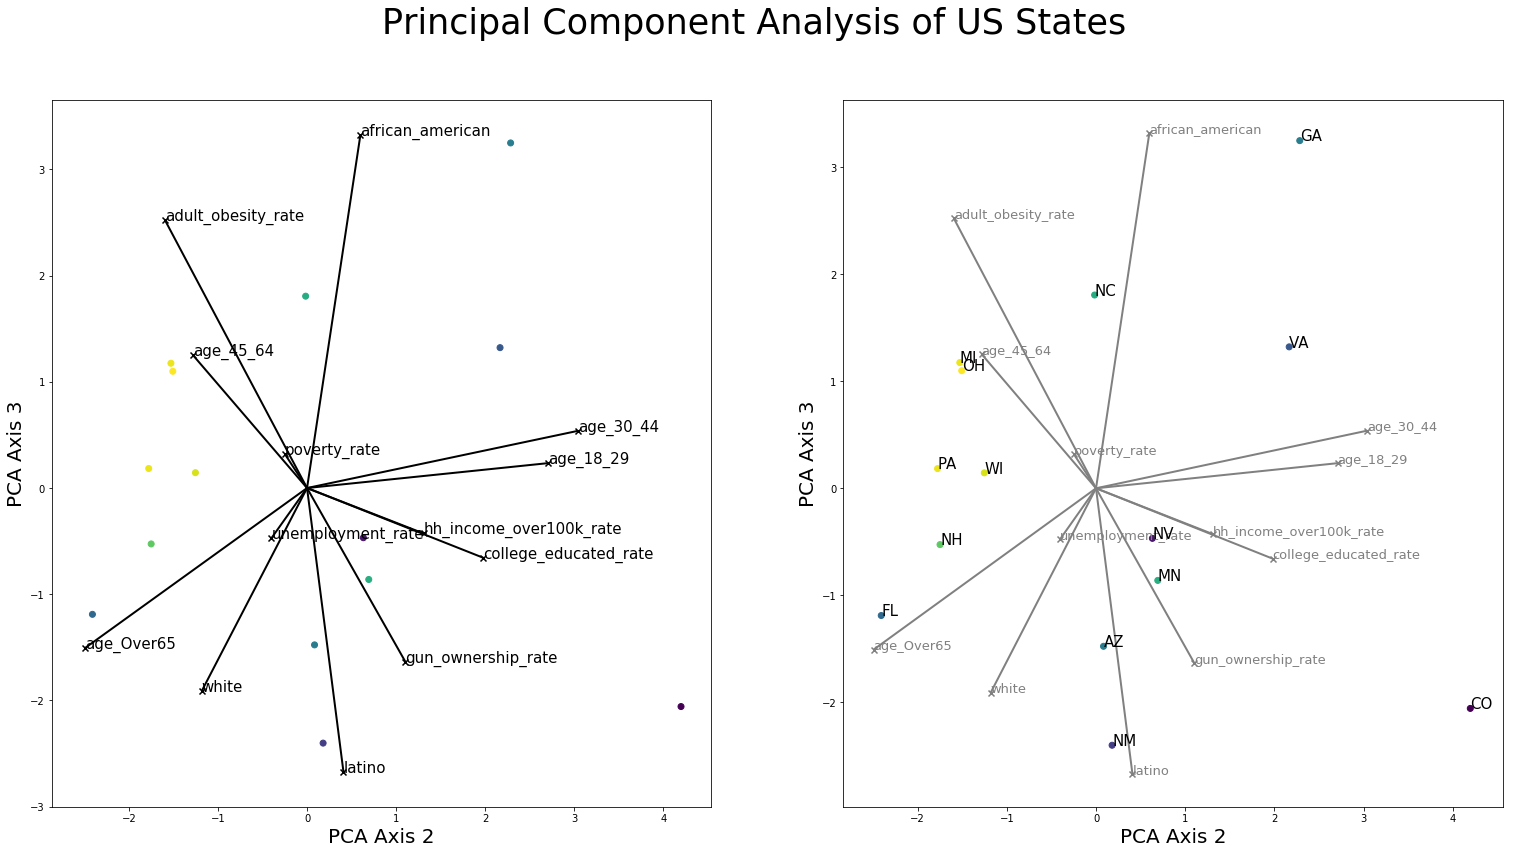

In [215]:
X, info = data_processing(data)
c_alpha, d_alpha = pca_analysis(X, components=3)
poll_plot(c_alpha, d_alpha, info, scale_factor=6)

In yellow, the states where Trump most outperformed his polls (MI, OH, PA). In blue, the states where he most underperformed his polls. The polling error in Trump's favor is strongly correlated with with high adult obesity rates, high African-American population, and low latino population.